In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import os
import numpy as np
import cv2
import matplotlib.patches as patches
import random
from sklearn.utils import shuffle
import shutil

In [17]:
from tensorflow import keras

In [3]:
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import itertools

Using TensorFlow backend.


In [4]:
!ls

base_dir		   data-prep.ipynb			   storage
cancer_detection_v2.ipynb  histopathologic_cancer_detection.ipynb


In [5]:
os.path.join('storage','hisp','train_labels.csv')

'storage/hisp/train_labels.csv'

In [6]:
df = pd.read_csv(os.path.join('storage','hisp','train_labels.csv'))
df.head()
train_path = 'storage/hisp/train/'
test_path = 'storage/hisp/test/'

In [7]:
df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [8]:
TRAIN_DIR = train_path

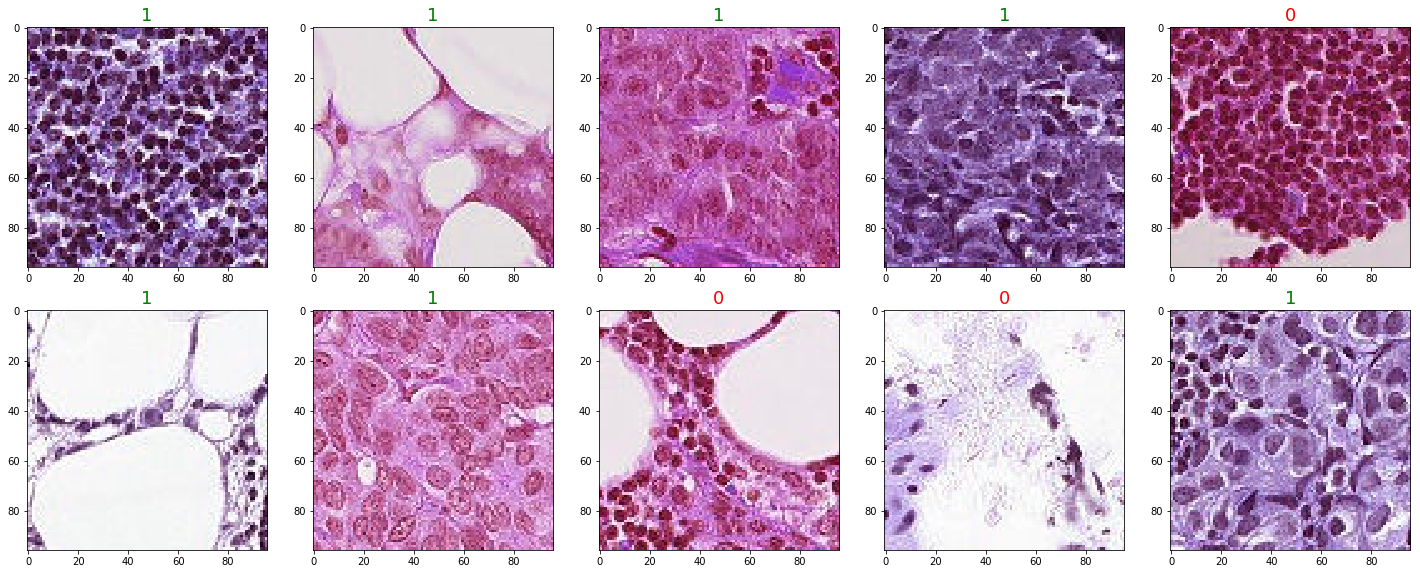

In [21]:
fig = plt.figure(figsize = (20,8))
index = 1
for i in np.random.randint(low = 0, high = df.shape[0], size = 10):
    file = TRAIN_DIR + df.iloc[i]['id'] + '.tif'
    img = cv2.imread(file)
    ax = fig.add_subplot(2, 5, index)
    ax.imshow(img, cmap = 'gray')
    index = index + 1
    color = ['green' if df.iloc[i].label == 1 else 'red'][0]
    ax.set_title(df.iloc[i].label, fontsize = 18, color = color)
plt.tight_layout()
plt.show()

In [22]:
# removing this image because it caused a training error previously
df[df['id'] != 'dd6dfed324f9fcb6f93f46f32fc800f2ec196be2']

# removing this image because it's black
df[df['id'] != '9369c7278ec8bcc6c880d99194de09fc2bd4efbe']
df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [23]:
SAMPLE_SIZE = 80000
# take a random sample of class 0 with size equal to num samples in class 1
df_0 = df[df['label'] == 0].sample(SAMPLE_SIZE, random_state = 0)
# filter out class 1
df_1 = df[df['label'] == 1].sample(SAMPLE_SIZE, random_state = 0)

# concat the dataframes
df_train = pd.concat([df_0, df_1], axis = 0).reset_index(drop = True)
# shuffle
df_train = shuffle(df_train)

df_train['label'].value_counts()

1    80000
0    80000
Name: label, dtype: int64

In [24]:
# train_test_split
# stratify=y creates a balanced validation set.
y = df_train['label']

df_train, df_val = train_test_split(df_train, test_size = 0.1, random_state = 0, stratify = y)

In [25]:
print(len(os.listdir('base_dir/train_dir/0')))
print(len(os.listdir('base_dir/train_dir/1')))

72000
72000


In [29]:
from keras.preprocessing.image import ImageDataGenerator
IMAGE_SIZE = 96
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'
test_path = 'storage/hisp/test/'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 32
val_batch_size = 32


train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)


datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 144000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.


In [19]:
def build_basic_model(input_shape):
    model = keras.models.Sequential()
    model.add( keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=input_shape ) )
    model.add( keras.layers.MaxPooling2D(2,2) )
    model.add( keras.layers.Conv2D( 32, (3,3), activation='relu' ) )
    model.add( keras.layers.MaxPooling2D(2,2) )
    model.add( keras.layers.Conv2D( 64, (3,3), activation='relu' ) )
    model.add( keras.layers.MaxPooling2D(2,2) )
    model.add( keras.layers.Flatten())
    model.add( keras.layers.Dense(512, activation='relu'))
    model.add( keras.layers.Dense(128, activation='relu'))
    model.add( keras.layers.Dense(10, activation='sigmoid'))
    model.add( keras.layers.Dense(2, activation='softmax'))
    
    return model

In [15]:
def resnet_50_model():
    
    #Load the VGG model
    resnet = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(96,96, 3))
    
    # Freeze the layers except the last 4 layers# Freeze 
    for layer in resnet.layers[:-4]:
        layer.trainable = False
    
    model = tf.keras.Sequential()
    
    model.add(resnet)
    
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(512, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(2, activation='softmax'))
    model.summary()
    return model

In [20]:
model = build_basic_model((96,96, 3))

In [16]:
model = resnet_50_model()

/usr/local/lib/python3.5/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 3, 3, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               9437696   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 1026      
Total params: 33,026,434
Trainable params: 10,493,442
Non-trainable params: 22,532,992
_________________________________________________________________


In [27]:

optimizer = tf.keras.optimizers.Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])

In [28]:
filepath = "fit_gen_checkpoint_3.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose = 1, 
                             save_best_only = True, mode = 'max')


# Uncomment below section if your model needs LR scheduler. 
# As we are using lr_momentum and decay we better not use LR_scheduler.

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc', factor = 0.5, patience = 2, verbose = 1, mode = 'max', min_lr = 0.00001)                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_gen, steps_per_epoch = train_steps, 
                    validation_data = val_gen,
                    validation_steps = val_steps,
                    epochs = 5,
                    verbose = 1,
                    callbacks = callbacks_list) #mention callbacks = callbacks_list if you use LR_scheduler


Epoch 1/5
 6729/14400 [=============>................] - ETA: 32:49 - loss: 0.4957 - acc: 0.7673

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



13703/14400 [===========================>..] - ETA: 2:58 - loss: 0.4742 - acc: 0.7804

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 2872/14400 [====>.........................] - ETA: 31:49 - loss: 0.4239 - acc: 0.8085

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 6668/14400 [============>.................] - ETA: 21:19 - loss: 0.4085 - acc: 0.8184

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



10238/14400 [====================>.........] - ETA: 11:30 - loss: 0.3983 - acc: 0.8234

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



13537/14400 [===========================>..] - ETA: 2:23 - loss: 0.3887 - acc: 0.8285

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 2740/14400 [====>.........................] - ETA: 32:21 - loss: 0.3357 - acc: 0.8563

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 6536/14400 [============>.................] - ETA: 21:57 - loss: 0.3340 - acc: 0.8577

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



10092/14400 [====================>.........] - ETA: 12:01 - loss: 0.3318 - acc: 0.8587

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



13986/14400 [============================>.] - ETA: 1:09 - loss: 0.3272 - acc: 0.8612

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 2569/14400 [====>.........................] - ETA: 33:04 - loss: 0.2951 - acc: 0.8775

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 6444/14400 [============>.................] - ETA: 22:07 - loss: 0.2882 - acc: 0.8817

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 9968/14400 [===================>..........] - ETA: 12:18 - loss: 0.2867 - acc: 0.8816

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



13825/14400 [===========================>..] - ETA: 1:35 - loss: 0.2834 - acc: 0.8828

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 2794/14400 [====>.........................] - ETA: 31:59 - loss: 0.2490 - acc: 0.9004

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 6724/14400 [=============>................] - ETA: 21:10 - loss: 0.2483 - acc: 0.9006

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 9591/14400 [==================>...........] - ETA: 13:16 - loss: 0.2454 - acc: 0.9013

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



14076/14400 [============================>.] - ETA: 53s - loss: 0.2455 - acc: 0.9014

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [30]:
# Load the weights with the best validation accuracy
model.load_weights('fit_gen_checkpoint_3.h5')



In [31]:
hisp_dict = { 0:'No Hisp', 1: 'Found Hisp' }

In [ ]:
df_train.head()

In [ ]:
# selecting only 1000 data for MVP
df_X_test = df_train.sample(100)
#train = df
df_X_test.describe()

In [67]:
def prepareImages(train,m):
    print("Preparing images")
    X_train = np.zeros((m, 96, 96, 3))
    count = 0
    
    for id in train['id']:
        path = os.path.join(train_path, id)
        img = image.load_img(path+'.tif')
        x = image.img_to_array(img)
        x = preprocess_input(x)

        X_train[count] = x
        if (count%500 == 0):
            print("Processing image: ", count+1, ", ", id)
        count += 1
    
    return X_train

def prepare_labels(y):
    values = np.array(y)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    # print(integer_encoded)

    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    # print(onehot_encoded)

    y = onehot_encoded
    # print(y.shape)
    return y, label_encoder

def showImage(X,y,index):
    print("The class is ",y[index])
    plt.imshow(X[index])
    
def saveNpy(path, np_arr):
    np.save(path,np_arr)
    

In [58]:
df_X_test.head()

,id,label
43854,1770c1a2ca04b75bd8150b4ef8b828b519280e2a,0
144642,d519288ba526d9c3817390bea982c88945ee931c,1
116713,e5fd05258d63f358bf65081792c8ba64321b8b3a,1
15039,09efde3f2f37c4183aab793a987ae67bafcbe299,0
99998,f9cf55f20afe6ee06eb4ad2933995652e5b87494,1


In [59]:
X_test = prepareImages(df_X_test,len(df_X_test))


Preparing images
Processing image:  1 ,  09efde3f2f37c4183aab793a987ae67bafcbe299


In [66]:
X_test.shape

(1000, 96, 96, 3)

(1000, 96, 96, 3)
The class is  [0. 1.]


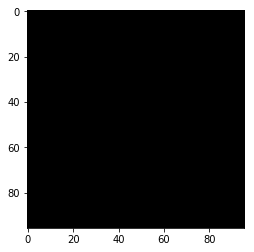

In [64]:
labels = df_X_test['label']
y_test, label_encoder = prepare_labels(labels)
print(X_test.shape)
showImage(X_test,y_test,106)

In [38]:
y_hat = model.predict(X_test)

# Plot a random sample of 10 test images, their predicted labels and ground truth
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(X_test.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(np.squeeze(X_test[index]))
    predict_index = np.argmax(y_hat[index])
    true_index = np.argmax(y_test[index])
    # Set the title for each image
    ax.set_title("{} ({})".format(hisp_dict[predict_index], 
                                  hisp_dict[true_index]),
                                  color=("green" if predict_index == true_index else "red"))

NameError: name 'X_test' is not defined

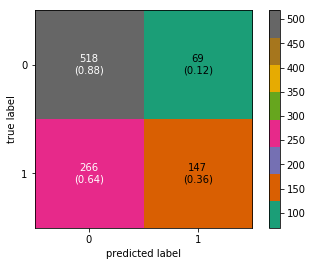

In [30]:
y_pred = model.predict(X_test)
y_pred_binary = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

from sklearn.metrics import confusion_matrix
# For this to work we need y_pred as binary labels not as probabilities

cm = confusion_matrix(y_true, y_pred_binary)

from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=cm,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                               cmap = 'Dark2')
plt.show()

In [31]:
from sklearn.metrics import classification_report
# Generate a classification report

report = classification_report(y_true, y_pred_binary, target_names = ['no_tumor', 'has_tumor'])
print(report)

             precision    recall  f1-score   support

   no_tumor       0.66      0.88      0.76       587
  has_tumor       0.68      0.36      0.47       413

avg / total       0.67      0.67      0.64      1000



In [68]:
#Folder Structure

'''
    * test_dir
        |-- test_images
'''

# We will be feeding test images from a folder into predict_generator().

# create test_dir
test_dir = 'test_dir'
os.mkdir(test_dir)
    
# create test_images inside test_dir
test_images = os.path.join(test_dir, 'test_images')
os.mkdir(test_images)

# check that the directory we created exists
os.listdir('test_dir')


['test_images']

In [70]:
# # Transfer the test images into image_dir
# test_list = os.listdir('../input/test')

# for image in test_list:    
#     fname = image
#     # source path to image
#     src = os.path.join('../input/test', fname)
#     # destination path to image
#     dst = os.path.join(test_images, fname)
#     # copy the image from the source to the destination
#     shutil.copyfile(src, dst)
# print('Total Test Images = ',len(os.listdir('test_dir/test_images')))

In [71]:
# Transfer the test images into image_dir
# test_list = os.listdir('../input/test')

# for image in test_list:    
#     fname = image
#     # source path to image
#     src = os.path.join('../input/test', fname)
#     # destination path to image
#     dst = os.path.join(test_images, fname)
#     # copy the image from the source to the destination
#     shutil.copyfile(src, dst)
# print('Total Test Images = ',len(os.listdir('test_dir/test_images')))

In [74]:
test_path ='test_dir'
test_gen = datagen.flow_from_directory(test_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 57458 images belonging to 1 classes.


In [75]:
num_test_images = 57458 #len(os.listdir('test_dir/test_images')

predictions = model.predict_generator(test_gen, steps=num_test_images, verbose=1)

if predictions.shape[0] == num_test_images:
    print('All Predictions Done!')
else:
    print('Error!')

57458/57458 [==============================] - 1271s 22ms/step
All Predictions Done!


In [76]:
# Put the predictions into a dataframe
df_preds = pd.DataFrame(predictions, columns=['no_tumor', 'has_tumor'])
df_preds.head()

,no_tumor,has_tumor
0,0.019565,0.980435
1,0.365372,0.634628
2,0.311475,0.688525
3,0.926251,0.073749
4,0.989401,0.010599


In [77]:
# This outputs the file names in the sequence in which the generator processed the test images.
test_filenames = test_gen.filenames

# add the filenames to the dataframe
df_preds['file_names'] = test_filenames

# Create an id column
# A file name now has this format: 
# images/00006537328c33e284c973d7b39d340809f7271b.tif

# This function will extract the id:
# 00006537328c33e284c973d7b39d340809f7271b
def extract_id(x):
    
    # split into a list
    a = x.split('/')
    # split into a list
    b = a[1].split('.')
    extracted_id = b[0]
    
    return extracted_id

df_preds['id'] = df_preds['file_names'].apply(extract_id)

df_preds.head()

,no_tumor,has_tumor,file_names,id
0,0.019565,0.980435,test_images/00006537328c33e284c973d7b39d340809...,00006537328c33e284c973d7b39d340809f7271b
1,0.365372,0.634628,test_images/0000ec92553fda4ce39889f9226ace43ca...,0000ec92553fda4ce39889f9226ace43cae3364e
2,0.311475,0.688525,test_images/00024a6dee61f12f7856b0fc6be20bc7a4...,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2
3,0.926251,0.073749,test_images/000253dfaa0be9d0d100283b22284ab2f6...,000253dfaa0be9d0d100283b22284ab2f6b643f6
4,0.989401,0.010599,test_images/000270442cc15af719583a8172c87cd2bd...,000270442cc15af719583a8172c87cd2bd9c7746


In [78]:
# Get the predicted labels.
# We were asked to predict a probability that the image has tumor tissue
y_pred = df_preds['has_tumor']

# get the id column
image_id = df_preds['id']

In [79]:
submission = pd.DataFrame({'id':image_id, 
                           'label':y_pred, 
                          }).set_index('id')

submission.to_csv('submission.csv', columns=['label'])

In [80]:
submission.head()

,label
id,
00006537328c33e284c973d7b39d340809f7271b,0.980435
0000ec92553fda4ce39889f9226ace43cae3364e,0.634628
00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0.688525
000253dfaa0be9d0d100283b22284ab2f6b643f6,0.073749
000270442cc15af719583a8172c87cd2bd9c7746,0.010599
